## 2.1 human-activity-classification

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2022.4.26 </div>
<div style="text-align: right\"> Last update: 2022.4.26</div>

- 출처 : https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

from scipy.signal import find_peaks

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In [4]:
import tensorflow as tf
from tensorflow import keras

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [7]:
# reading raw data file
columns = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

In [8]:
df = pd.read_csv('data/wisdom/WISDM_ar_v1.1_raw.txt', header = None, names=columns, 
                 on_bad_lines='skip')
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

In [9]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [10]:
df.shape

(1098203, 6)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float64
 4   y_axis     1098203 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


### EDA

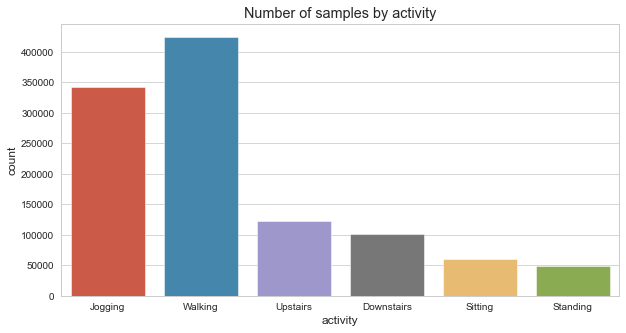

In [12]:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.countplot(x = 'activity', data = df)
plt.title('Number of samples by activity')
plt.show()

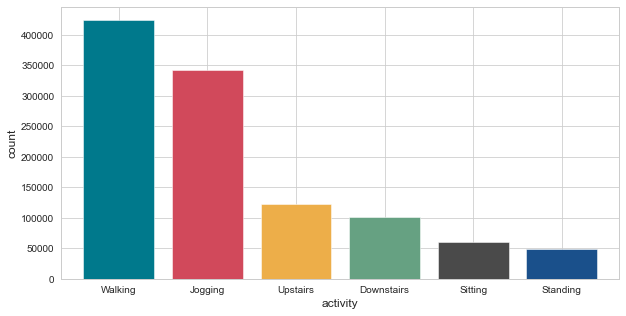

In [13]:
plt.figure(figsize = (10, 5))
df['activity'].value_counts().plot(kind = 'bar', color = colors, rot= 0, 
                                   width = 0.8)
plt.xlabel('activity')
plt.ylabel('count')
plt.show()

- 행동별 빈도 차이가 있다.  
- class imbalance

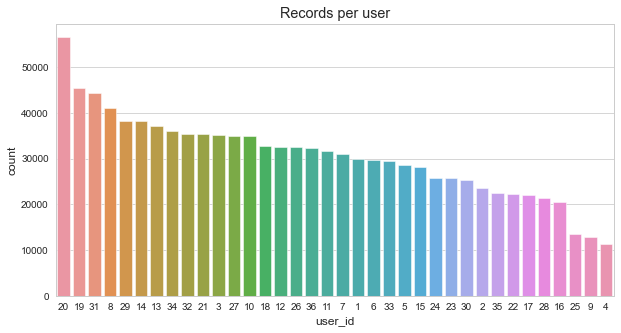

In [15]:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.countplot(x = 'user_id', data = df, order = df['user_id'].value_counts().index)
plt.title('Records per user')
plt.show()

In [16]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

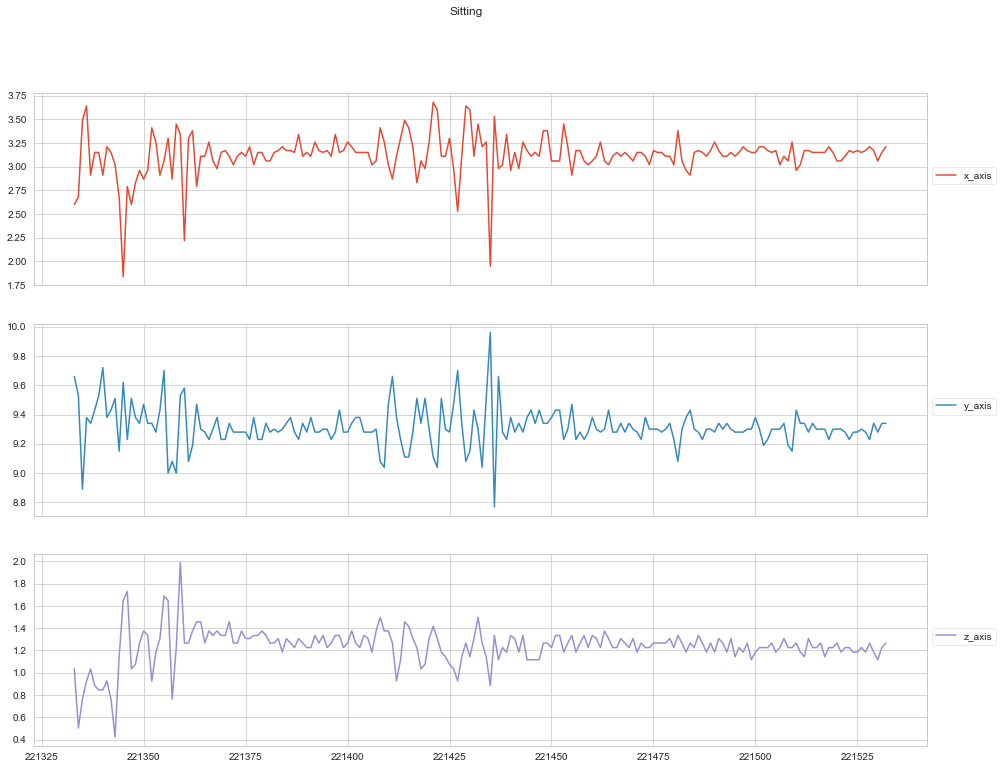

In [17]:
plot_activity("Sitting", df);

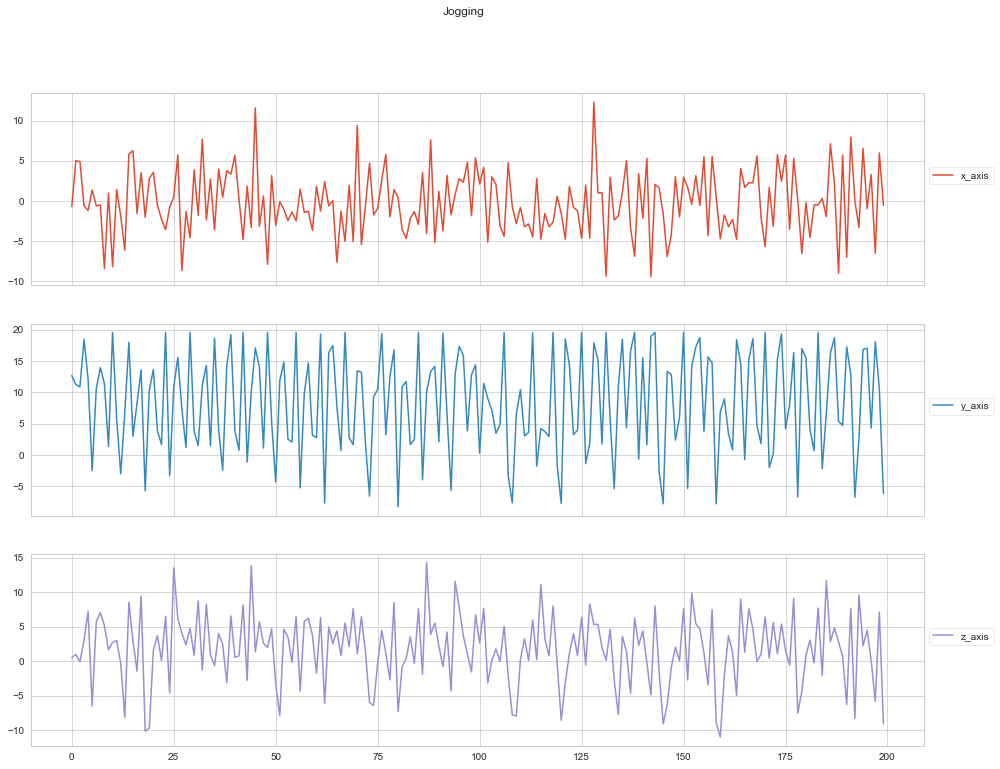

In [18]:
plot_activity("Jogging", df);

In [19]:
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

In [20]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

In [21]:
df_train.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
8489,17,Walking,57869902574000,0.019955,0.252293,-0.090959
8490,17,Walking,57870012316000,-0.055118,0.297966,-0.099228
8491,17,Walking,57870122301000,-0.085505,0.257187,-0.124035
8492,17,Walking,57870222246000,-0.035456,0.284917,-0.085446
8493,17,Walking,57870332292000,-0.035456,0.293073,-0.107497


In [22]:
df_test.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.146278,0.596472,0.118522
1,33,Jogging,49106062271000,0.602662,0.426830,0.209481
2,33,Jogging,49106112167000,0.588363,0.381157,0.000000
3,33,Jogging,49106222305000,-0.135553,1.292986,0.628442
4,33,Jogging,49106332290000,-0.210626,0.527963,1.474634


In [23]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [24]:
TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [26]:
X_train.shape

(22454, 200, 3)

In [28]:
X_train[:3]

array([[[ 0.01995467,  0.25229341, -0.09095876],
        [-0.05511811,  0.29796647, -0.09922774],
        [-0.08550471,  0.25718695, -0.12403466],
        ...,
        [ 0.08072789, -0.49478671, -0.08544611],
        [ 0.16116301, -0.04131885,  0.72215742],
        [ 0.20584919,  0.52306922,  1.12458108]],

       [[ 0.13613874,  0.10059377,  0.46581909],
        [ 0.14686343,  0.02229717,  0.48235709],
        [ 0.26126005,  0.10548731,  0.61466072],
        ...,
        [-0.01936916, -0.39528479,  0.12403467],
        [ 0.85469252,  0.97327473,  1.09426145],
        [ 0.22193619,  0.43172323, -0.46306278]],

       [[ 0.21121152,  0.7710085 , -0.00551265],
        [ 0.26126005, -0.14734551, -0.50165133],
        [-0.16057749,  0.05981437,  0.02480694],
        ...,
        [ 0.50792777,  0.57852934,  1.11079939],
        [ 0.37744412,  0.44966623,  0.13230365],
        [ 0.36135709,  0.47739617, -0.52645828]]])

In [30]:
y_train[:3]

array([['Walking'],
       ['Walking'],
       ['Walking']], dtype='<U10')

In [31]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [32]:
print(X_train.shape, y_train.shape)

(22454, 200, 3) (22454, 6)


In [33]:
model = keras.Sequential()

model.add(keras.layers.Bidirectional(keras.layers.LSTM(units = 128,
                                                      input_shape = [X_train.shape[1], 
                                                                     X_train.shape[2]])))

model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [34]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/20
316/316 [==============================] - 16s 32ms/step - loss: 1.0981 - acc: 0.6206 - val_loss: 1.1271 - val_acc: 0.6496
Epoch 2/20
316/316 [==============================] - 9s 29ms/step - loss: 0.7874 - acc: 0.7271 - val_loss: 0.7705 - val_acc: 0.7569
Epoch 3/20
316/316 [==============================] - 9s 28ms/step - loss: 0.5911 - acc: 0.7926 - val_loss: 0.5554 - val_acc: 0.8099
Epoch 4/20
316/316 [==============================] - 9s 28ms/step - loss: 0.4538 - acc: 0.8371 - val_loss: 0.3242 - val_acc: 0.8998
Epoch 5/20
316/316 [==============================] - 9s 28ms/step - loss: 0.3924 - acc: 0.8555 - val_loss: 0.5576 - val_acc: 0.8201
Epoch 6/20
316/316 [==============================] - 9s 28ms/step - loss: 0.3275 - acc: 0.8836 - val_loss: 0.4574 - val_acc: 0.8513
Epoch 7/20
316/316 [==============================] - 9s 28ms/step - loss: 0.3025 - acc: 0.8987 - val_loss: 0.5082 - val_acc: 0.8642
Epoch 8/20
316/316 [==============================] - 9s 28ms/step -

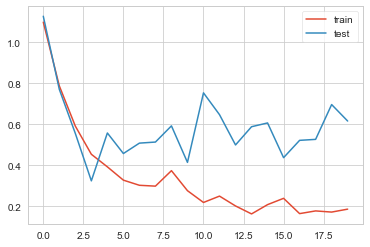

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [36]:
model.evaluate(X_test, y_test)

156/156 [==============================] - 2s 10ms/step - loss: 0.5058 - acc: 0.8586


[0.505788266658783, 0.8585737347602844]

In [37]:
y_pred = model.predict(X_test)

In [38]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

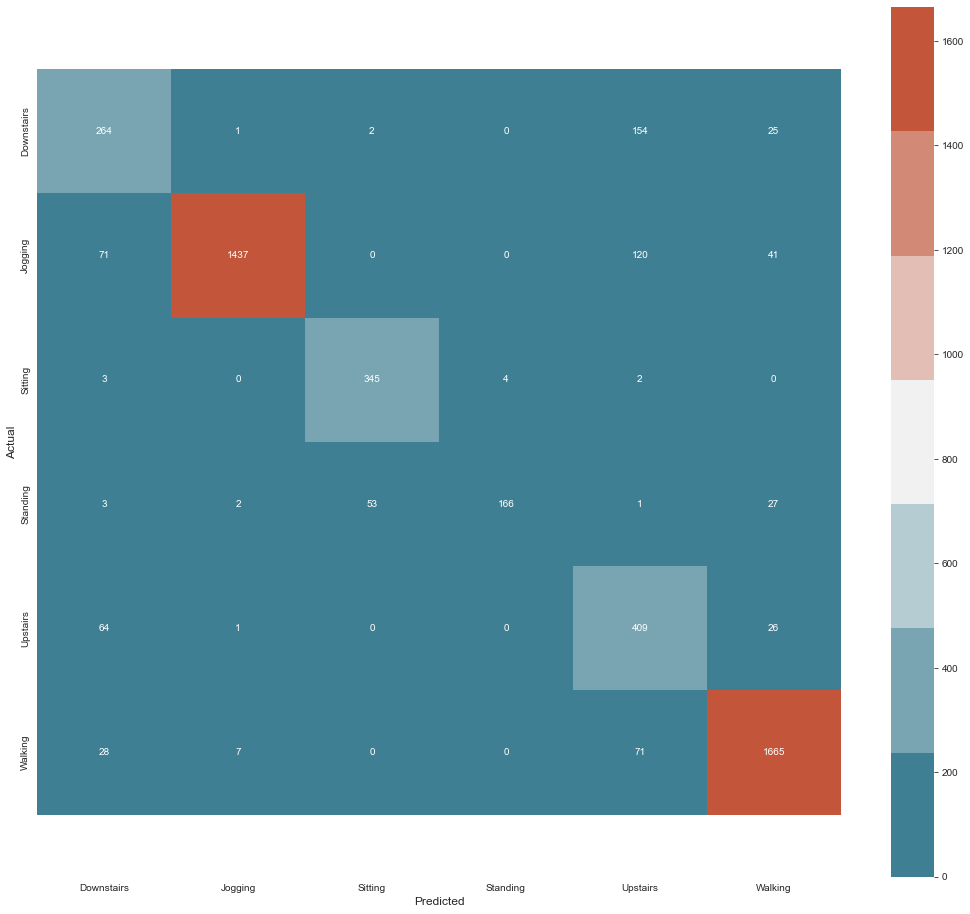

In [39]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

## 또다른 방법

In [43]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df_har = pd.read_csv('data/wisdom/WISDM_ar_v1.1_raw.txt', header = None, names=columns, 
                 on_bad_lines='skip')

df_har = df_har.dropna()

df_har['z-axis'] = df_har['z-axis'].str.replace(';', '')
df_har['z-axis'] = df_har['z-axis'].apply(lambda x:float(x))
df = df_har[df_har['timestamp'] != 0]

df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

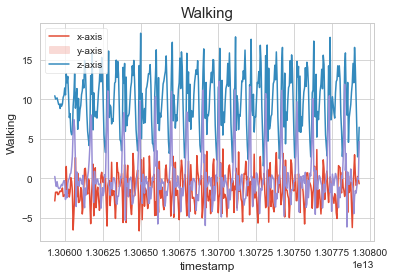

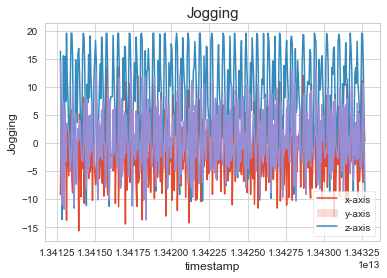

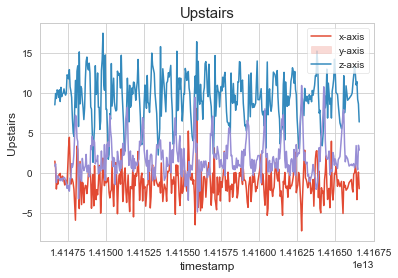

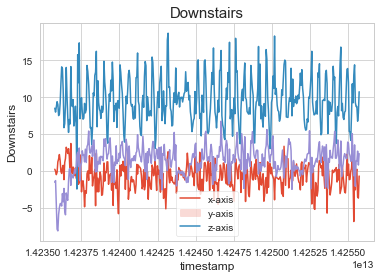

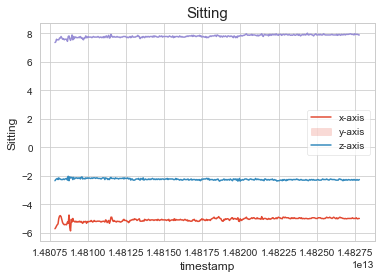

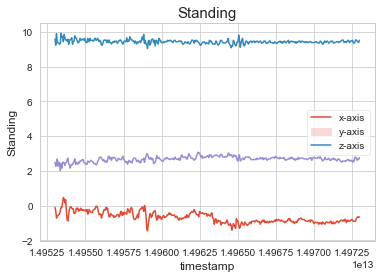

In [44]:
activities = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
for i in activities:
    data36 = df[(df['user'] == 36) & (df['activity'] == i)][:400]
    sns.lineplot(y = 'x-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'y-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'z-axis', x = 'timestamp', data = data36)
    plt.legend(['x-axis', 'y-axis', 'z-axis'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

데이터 준비

In [45]:
random_seed = 42   
n_time_steps = 50 
n_features = 3 
step = 10 
n_classes = 6 
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015

In [46]:
segments = []
labels = []

for i in range(0,  df.shape[0]- n_time_steps, step):  
    xs = df['x-axis'].values[i: i + 50]
    ys = df['y-axis'].values[i: i + 50]
    zs = df['z-axis'].values[i: i + 50]

    label = stats.mode(df['activity'][i: i + 50])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

#reshape the segments which is (list of arrays) to a list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [47]:
reshaped_segments.shape

(108531, 50, 3)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, 
                                                    random_state = random_seed)

모델 빌딩

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout

In [51]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5)) 
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/50
68/68 [==============================] - 2s 18ms/step - loss: 0.9369 - accuracy: 0.6692 - val_loss: 0.5738 - val_accuracy: 0.7997
Epoch 2/50
68/68 [==============================] - 1s 10ms/step - loss: 0.5344 - accuracy: 0.8127 - val_loss: 0.4644 - val_accuracy: 0.8306
Epoch 3/50
68/68 [==============================] - 1s 10ms/step - loss: 0.4579 - accuracy: 0.8338 - val_loss: 0.4168 - val_accuracy: 0.8466
Epoch 4/50
68/68 [==============================] - 1s 10ms/step - loss: 0.4092 - accuracy: 0.8493 - val_loss: 0.3785 - val_accuracy: 0.8606
Epoch 5/50
68/68 [==============================] - 1s 10ms/step - loss: 0.3771 - accuracy: 0.8616 - val_loss: 0.3643 - val_accuracy: 0.8633
Epoch 6/50
68/68 [==============================] - 1s 10ms/step - loss: 0.3465 - accuracy: 0.8719 - val_loss: 0.3184 - val_accuracy: 0.8803
Epoch 7/50
68/68 [==============================] - 1s 10ms/step - loss: 0.3152 - accuracy: 0.8848 - val_loss: 0.2971 - val_accuracy: 0.8922
Epoch 8/50
68

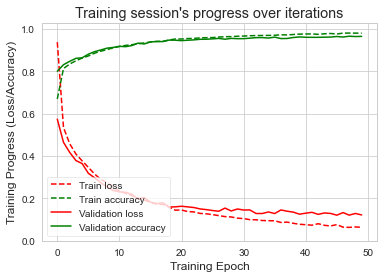

In [54]:
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

In [55]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

22/22 [==============================] - 0s 4ms/step - loss: 0.1176 - accuracy: 0.9661
Test Accuracy : 0.966093897819519
Test Loss : 0.11760962754487991


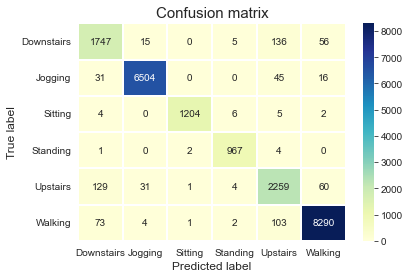

In [57]:
predictions = model.predict(X_test)
class_labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()